# Stochastic Backpropagation Algorithm


Neural network with:  
- Number of hidden nodes = 10  
  - Number of input nodes = 2 (input pattern dimension)  
  -  Number of output nodes = 2 (number of categories)   
- Convergence criterion = 0.1  
- Convergence rate (i.e. step size) = 0.1  
- Activation function f(net) = a.tanh (b.net), and a=1.716, b=2/3
- Target vectors for (ω1, ω2) = [1, -1]t, [-1, 1]t
- Standardized input patterns and random uniform weights initialization


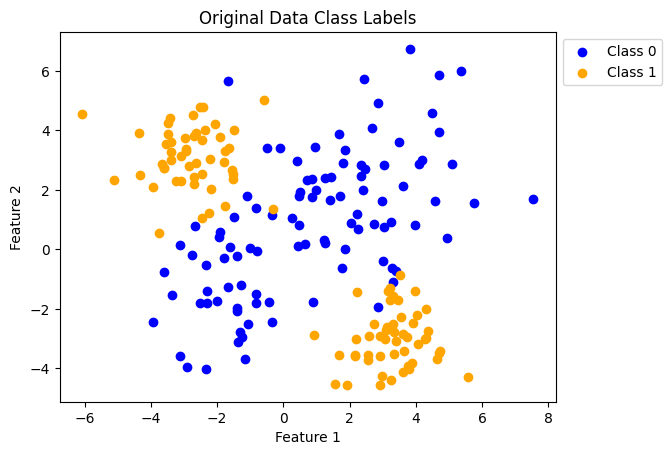

Final weights:
[[-0.06409404 -0.20168909  0.16833437]
 [-0.76712875 -0.76800307  0.51485744]
 [-0.04448869 -0.35130024  0.17569795]
 [-0.06779468  0.30619918  0.45988667]
 [-0.18421212  0.04063498 -0.44899632]
 [ 0.88456396 -1.77347678  0.97000745]
 [ 0.12328906 -0.03130921 -0.51727802]
 [-0.34287752  0.13306734  0.48794326]
 [ 1.73215243 -1.14219085 -1.01676541]
 [-0.19126028  0.06496451 -1.47293598]]
[[-0.08053738 -0.67793373 -0.18820512  0.16029116 -0.1741502   0.90370681
  -0.08200975  0.13785308 -0.76150558 -0.19394212 -1.31403895]
 [ 0.11586786  0.64378845  0.15030662 -0.26447944 -0.01335591 -0.89061843
   0.0083216   0.0636771   0.78606262  0.38999232  1.4021291 ]]



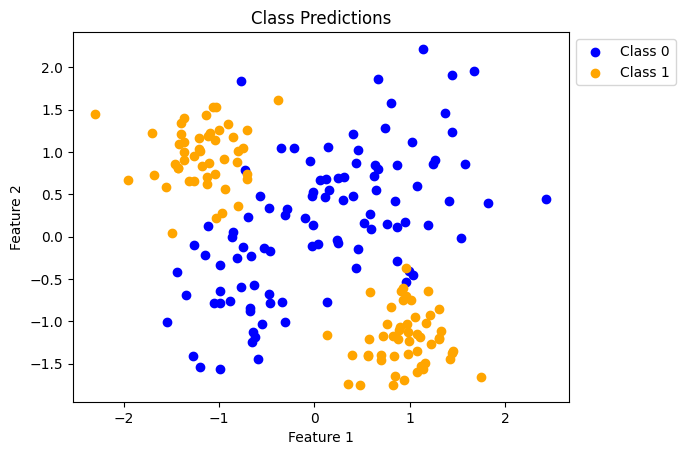

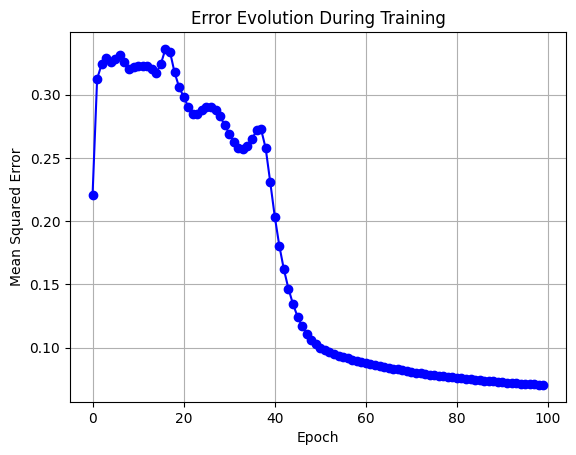

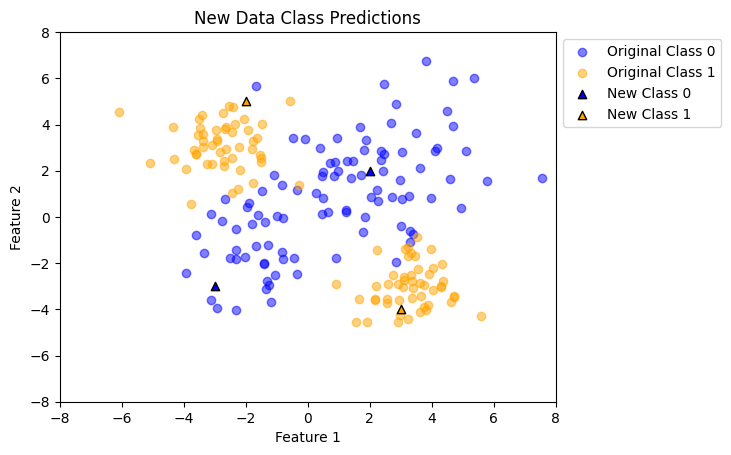

In [47]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def init_weights(no, ni, nh):
    '''Initialize weights, including bias.'''
    # Input-to-hidden layer
    d = 1 / np.sqrt(ni + 1)  # Adjusting for bias
    w_ih = np.random.uniform(-d, d, size=(nh, ni + 1))
    # Hidden-to-output layer
    n = 1 / np.sqrt(nh + 1)  # Adjusting for bias
    w_ho = np.random.uniform(-n, n, size=(no, nh + 1))
    return w_ih, w_ho

def calc_net(w, x):
    '''Calculate net input, including proper bias handling.'''
    # Add bias term for the hidden layer calculations
    return np.dot(w, x)       

def activation(a, b, net):
    '''Vectorized tanh activation function.'''
    return a * np.tanh(b * net)

def derivative_activation(a, b, net):
    '''Derivative of tanh activation for vectorized inputs.'''
    return a * b * (1 - np.tanh(b * net) ** 2)

def update_weights(x, t, w_ih, w_ho, a, b, eta):
    # Forward pass
    net_j = calc_net(w_ih, np.append(x, 1))  # Ensure x has bias appended
    y = activation(a, b, net_j)
    
    # Here, append bias to y for the output layer calculation
    y_with_bias = np.append(y, 1)  
    net_k = calc_net(w_ho, y_with_bias)  # w_ho should be expecting this size
    z_out = activation(a, b, net_k)
    
    # Backward pass: Compute deltas
    error_k = t - z_out
    delta_k = error_k * derivative_activation(a, b, net_k)
    error_j = np.dot(w_ho[:, :-1].T, delta_k) * derivative_activation(a, b, net_j)
    
    # Update weights
    w_ho += eta * np.outer(delta_k, y_with_bias)
    w_ih += eta * np.outer(error_j, np.append(x, 1))
    
    return w_ih, w_ho, z_out

def classify(train, target, theta, eta, epochs, a, b, no, ni, nh):
    
    w_ih, w_ho = init_weights(no, ni, nh)
    errors = []
    predictions = np.zeros(train.shape[0])  # Initialize predictions array

    for epoch in range(epochs):
        epoch_error = []

        for i, (x, t) in enumerate(zip(train, target)):
            # update weights
            w_ih, w_ho, z_out = update_weights(x, t, w_ih, w_ho, a, b, eta)
            
            # get error
            e = np.mean(0.5 * (t - z_out) ** 2)
            epoch_error.append(e)

            # make prediction
            predicted_class = 0 if z_out[0] > z_out[1] else 1
            predictions[i] = predicted_class  # Store prediction
        
        mean_error = np.mean(epoch_error)
        errors.append(mean_error)

        if mean_error < theta:
            print(f'Convergence achieved after {epoch + 1} iterations with mean error {mean_error}.')
            break

    # final results
    print(f"Final weights:\n{w_ih}\n{w_ho}\n")

    return w_ih, w_ho, predictions, errors

def standardize_data(d):
    '''Standardize data to have mean 0 and standard deviation 1.'''
    mean = np.mean(d, axis=0)
    std = np.std(d, axis=0)
    return (d - mean) / std

def classify_new_points(new_data, w_ih, w_ho, a, b):
    new_data = standardize_data(new_data)
    predictions = np.zeros(new_data.shape[0])  # Initialize predictions array
    for i, x in enumerate(new_data):
        net_j = calc_net(w_ih, np.append(x, 1))
        y = activation(a, b, net_j)
        y_with_bias = np.append(y, 1)
        net_k = calc_net(w_ho, y_with_bias)
        z_out = activation(a, b, net_k)
        predicted_class = 0 if z_out[0] > z_out[1] else 1
        predictions[i] = predicted_class
    
    return predictions

def get_data_from_csv(file_path):
    data = pd.read_csv(file_path)
    # Assuming the last column is the class label and the rest are features
    train = standardize_data(data.iloc[:, :-1].values)
    labels = data.iloc[:, -1].values
    
    # Get target vectorss for samples in using target vector [1, -1] for feature 1 and [-1, 1] for feature 2
    target = np.array([[1, -1] if label == 0 else [-1, 1] for label in labels])
    
    return train, target

def plot_classes_overlay(original_data, original_labels, new_data, new_predictions, title='Overlayed Class Predictions'):
    
    # Set colors for each class
    colors = {0: 'blue', 1: 'orange'}  # Adjust as needed, assuming 0 and 1 are the class labels
    
    # Plot original data
    for class_label, color in colors.items():
        # Filter original data by class
        idx_orig = original_labels == class_label
        plt.scatter(original_data[idx_orig, 0], original_data[idx_orig, 1], color=color, label=f'Original Class {class_label}', alpha=0.5)
    
    # Plot new predictions
    for class_label, color in colors.items():
        # Filter new data by predicted class
        idx_new = new_predictions == class_label
        plt.scatter(new_data[idx_new, 0], new_data[idx_new, 1], color=color, label=f'New Class {class_label}', marker='^', edgecolor='k')
    

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    # Position the legend outside the plot area on the right side
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust bbox_to_anchor as needed
    plt.show()

def scatter_plot(features, labels, title="Scatter Plot with Class Labels"):
    colors = {0: 'blue', 1: 'orange'}
    
    for label, color in colors.items():
        idx = labels == label
        plt.scatter(features[idx, 0], features[idx, 1], label=f'Class {label}', color=color)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    # plt.xlim(-8, 8)
    # plt.ylim(-8, 8)
    plt.title(title)
    # Position the legend outside the plot area on the right side
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust bbox_to_anchor as needed
    plt.show()

def plot_error(errors):
    plt.figure()
    plt.plot(errors, marker='o', linestyle='-', color='blue')
    plt.title('Error Evolution During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()

# Step 1: Load the CSV file
data = pd.read_csv("feature_data.csv").values
# Extract features and labels
features = data[:, :2]  # Assuming the first two columns are features
labels = data[:, 2]    # Assuming the third column contains the class labels
scatter_plot(features, labels, "Original Data Class Labels")

a = 1.716
b = 2/3   
theta=0.01                          # convergence criterion to stop
eta=0.01                            # rate / step size
nh=10                              # number of hidden nodes; 10 + bias
ni=2                               # dimension of input vector = number of input nodes; 2 + bias
no=2                               # number of classes / number of output nodes
epochs = 100

# Example usage:
file_path = "feature_data.csv"  # Adjust to your CSV file's path
train, target = get_data_from_csv(file_path)
w_ih, w_ho, predictions, errors = classify(train, target, theta, eta, epochs, a, b, no, ni, nh)
# Assuming `predictions` is a 1D numpy array with class predictions (1 or 2)
scatter_plot(train, predictions, "Class Predictions")
plot_error(errors)

# New data points D
D = np.array([[2, 2], [-3, -3], [-2, 5], [3, -4]])
# Classify new points using the trained model
predictions_D = classify_new_points(D, w_ih, w_ho, a, b)
# Plot original data and the new predictions for D
plot_classes_overlay(features, labels, D, predictions_D, title='New Data Class Predictions')
